In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from skmultilearn.model_selection import iterative_train_test_split
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from  tensorflow.keras import layers, optimizers, datasets
import  os
import tempfile
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
%matplotlib inline
os.environ['TF_CPP_MIN_LOG_LEVEL']='0'
pd.options.mode.use_inf_as_na = True
import pathlib
import random
import pandas as pd
data_root = pathlib.Path("./images去重")

In [2]:
data_root = pathlib.Path("./images去重")
LR = 0.0015
EPOCHS = 500
BATCH_SIZE = 64
SAVE_NAME = 'CNN_test14.h5'
IMAGE_SIZE = 256
RANDOM_W = 233
FLAG_1 = 1 #是否缩放至-1,1

In [3]:
#输出目标目录文件
# for item in data_root.iterdir():
#     print(item)

all_image_paths = list(data_root.glob('*'))
all_image_paths = [str(path) for path in all_image_paths]

image_count = len(all_image_paths)

# print(image_count)
# print(all_image_paths[:10])
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    return "Image (CC BY 2.0) " + ''.join(str(image_rel))



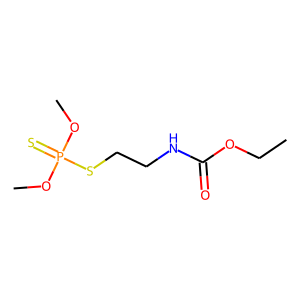

Image (CC BY 2.0) 6706_22100.sdf.png



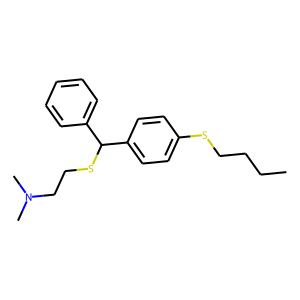

Image (CC BY 2.0) 1498_10240.sdf.png



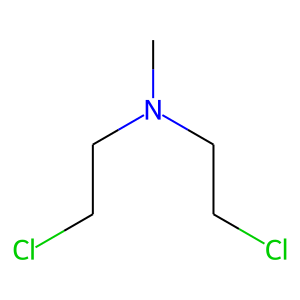

Image (CC BY 2.0) 5939_4033.sdf.png



In [4]:
for n in range(3):
  image_path = random.choice(all_image_paths)
  display.display(display.Image(image_path))
  print(caption_image(image_path))
  print()

In [5]:
df = pd.read_excel('re_All_Molecular去重.xlsx', "Sheet1", engine='openpyxl')
# df
#检查了两个变量：CID 和Response的数据格式是否正确
Response = list(df['Response'])
for i in range(len(Response)):
    if type(Response[i]) != float:
        print(i)
CIDtemp = list(df['CID'])
CID = []
for i in range(len(CIDtemp)):
    temp = str(CIDtemp[i]).split()[0]
    CID.append(temp)
for i in range(len(CID)):
    if type(CID[i]) != str:
        print(i)
image_CID = []
for i in range(len(all_image_paths)):
    temp_str = ''
    kaishi = 0
    jieshu = 0
    for j in range(len(all_image_paths[i])):
        if all_image_paths[i][j] == '_':
            kaishi = j
            continue
        if all_image_paths[i][j] == '.':
            jieshu = j
            break
    temp_str += all_image_paths[i][kaishi + 1: jieshu]
    image_CID.append(temp_str)
image_Response_lianxu = []
for i in range(len(image_CID)):
    if image_CID[i] in CID:
        image_Response_lianxu.append(Response[CID.index(image_CID[i])])
    else:
        print("eRROR! " + str(i))
# image_Response_lianxu 对应着  image_CID和 all_image_paths
print(len(image_Response_lianxu))
print(len(image_CID))
print(len(all_image_paths))
print(image_Response_lianxu[233])
print(image_CID[233])
print(all_image_paths[233])

duizi = []
for i in range(len(all_image_paths)):
    duizi.append([all_image_paths[i], image_Response_lianxu[i]])

7371
7371
7371
1.46
8554
images去重\1210_8554.sdf.png


In [6]:
np.random.seed(RANDOM_W) 
np.random.shuffle(duizi)
# duizi
# print(image_CID[1])
# print(image_Response_lianxu[1])
#预处理图片
def preprocess_image(image):
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image /= 255.0  # normalize to [0,1] range
    #缩放至-1 1
    if FLAG_1:
        image = 2*image - 1
    return image
#加载并预处理图片
def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


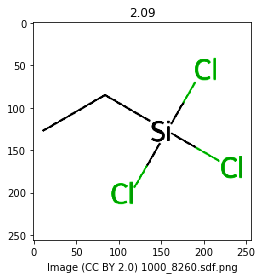

In [7]:
import matplotlib.pyplot as plt

img_path = all_image_paths[0]
label = image_Response_lianxu[0]

plt.imshow(load_and_preprocess_image(img_path))
plt.grid(False)
plt.xlabel(caption_image(img_path))
plt.title(image_Response_lianxu[0])
print()

In [8]:
train_dir = [i[0] for i in duizi[:4422]]
train_lianxu = [i[1] for i in duizi[:4422]]
val_dir = [i[0] for i in duizi[4422:5896]]
val_lianxu = [i[1] for i in duizi[4422:5896]]
test_dir = [i[0] for i in duizi[5896:7371]]
test_lianxu = [i[1] for i in duizi[5896:7371]]
# train_lianxu

#以下是弃用的方法
# #构建数据集，为了使用数据增强方法，这里可能需要更改
# path_ds = tf.data.Dataset.from_tensor_slices(train_dir)
# image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# #label_ds是预测的实际值
# label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(train_lianxu, tf.float32))
# #for label in label_ds.take(10):
# #   print(label)
# #打包为一个（图片，连续值）对数据集
# image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

# val_path_ds = tf.data.Dataset.from_tensor_slices(val_dir)
# val_image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# #label_ds是预测的实际值
# val_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(val_lianxu, tf.float32))
# #for label in label_ds.take(10):
# #   print(label)
# #打包为一个（图片，连续值）对数据集
# val_ds = tf.data.Dataset.zip((val_image_ds, val_label_ds))

# test_path_ds = tf.data.Dataset.from_tensor_slices(test_dir)
# test_image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# #label_ds是预测的实际值
# test_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(test_lianxu, tf.float32))
# #for label in label_ds.take(10):
# #   print(label)
# #打包为一个（图片，连续值）对数据集
# test_ds = tf.data.Dataset.zip((test_image_ds, test_label_ds))

ds = tf.data.Dataset.from_tensor_slices((train_dir, train_lianxu))
val_ds_wuhu = tf.data.Dataset.from_tensor_slices((val_dir, val_lianxu))
test_ds_wuhu = tf.data.Dataset.from_tensor_slices((test_dir, test_lianxu))
# The tuples are unpacked into the positional arguments of the mapped function
def load_and_preprocess_from_path_label(path, label):
  return load_and_preprocess_image(path), label
 
image_label_ds = ds.map(load_and_preprocess_from_path_label)
val_ds = val_ds_wuhu.map(load_and_preprocess_from_path_label)
test_ds = test_ds_wuhu.map(load_and_preprocess_from_path_label)
# print(test_ds)
# print(image_label_ds)
# import matplotlib.pyplot as plt
 
# plt.figure(figsize=(8,8))
# for n,image in enumerate(image_label_ds.take(4)):
#   plt.subplot(2,2,n+1)
#   plt.imshow(image)
#   plt.grid(False)
#   plt.xticks([])
#   plt.yticks([])
#   plt.xlabel(caption_image(all_image_paths[n]))
def configure_for_performance(ds, batch_size, buffer_size):
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def val_configure(ds, batch_size, buffer_size):
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def test_configure(ds, batch_size, buffer_size):
    ds = ds.shuffle(buffer_size=buffer_size)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

train_dataset = configure_for_performance(image_label_ds, BATCH_SIZE, 4423)
val_dataset = val_configure(val_ds, BATCH_SIZE, 1500)
test_dataset = test_configure(test_ds, 1, 1500)
# print(test_dataset)
# image_label_ds = image_label_ds.shuffle(buffer_size = 7371, reshuffle_each_iteration=False)
#过时的划分方法
# train_size = int(0.7 * 7371)
# val_size = int(0.15 * 7371)
# test_size = int(0.15 * 7371)

# full_dataset = image_label_ds
# full_dataset = full_dataset.shuffle(buffer_size = 7371, seed = 2333, reshuffle_each_iteration=False)
# train_dataset = full_dataset.take(train_size)
# test_dataset = full_dataset.skip(train_size)
# val_dataset = test_dataset.skip(val_size)
# test_dataset = test_dataset.take(test_size)

# print(train_dataset)
# BATCH_SIZE = 32
# image_count = len(all_image_paths)
# ds = image_label_ds.shuffle(buffer_size=image_count)
# ds = ds.repeat()
# ds = ds.batch(BATCH_SIZE)
# # 当模型在训练的时候，`prefetch` 使数据集在后台取得 batch。
# ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal_and_vertical"),
    keras.layers.RandomRotation(0.25, fill_mode = 'nearest'),
])

In [10]:
METRICS = [
    keras.metrics.MeanSquaredError(name='MSE'),
    keras.metrics.RootMeanSquaredError(name='RMSE'),
    keras.metrics.MeanAbsoluteError(name='MAE'),
    keras.metrics.MeanSquaredLogarithmicError(name='MSLE'),
    keras.metrics.CosineSimilarity(name='CosSimilarity'),
    keras.metrics.LogCoshError(name='LCE'),
#     tfa.metrics.r_square.RSquare(),
]
#16 32 64
#padding = 'same'
def make_model(metrics=METRICS, output_bias=None):
    model = keras.Sequential()
    #数据增强
    model.add(data_augmentation)
    model.add(keras.layers.Convolution2D(16, 3, 2, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), activation='relu'))
    #Batch_normalization
#     model.add(keras.layers.BatchNormalization(momentum = 0.9))
#尝试使用AveragePooling
#     model.add(keras.layers.AveragePooling2D(pool_size=(2, 2),padding='same'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'))
    #Batch_normalization
#     model.add(keras.layers.BatchNormalization(momentum = 0.9))
    model.add(keras.layers.Convolution2D(32, 3, 2, activation='relu'))
#     #Batch_normalization
#     model.add(keras.layers.BatchNormalization(momentum = 0.9))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'))
#     model.add(keras.layers.AveragePooling2D(pool_size=(2, 2),padding='same'))  
    model.add(keras.layers.Convolution2D(64, 3, 3, activation='relu'))
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2),padding='same'))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(300, activation='relu'))
    model.add(keras.layers.Dropout(.5))
    model.add(keras.layers.Dense(100, activation='relu'))
    model.add(keras.layers.Dropout(.25))
    model.add(keras.layers.Dense(20, activation='relu'))
    model.add(keras.layers.Dense(1))
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=LR), 
        loss='mean_squared_logarithmic_error',
#         loss='mean_squared_error',
        metrics = metrics)


    return model

In [11]:
model = make_model()

In [12]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [13]:
checkpoint = keras.callbacks.ModelCheckpoint(SAVE_NAME, 
                                             monitor='val_loss', 
                                             verbose=1, 
                                             save_best_only=True, 
                                             save_weights_only=False, 
                                             mode='auto')

In [14]:
baseline_history = model.fit(
    train_dataset,
#     batch_size=32,
    validation_data=val_dataset,
    callbacks=[checkpoint],
    epochs=EPOCHS,
    steps_per_epoch = 5160//BATCH_SIZE)

Epoch 1/500
 3/80 [>.............................] - ETA: 31s - loss: 0.5903 - MSE: 3.8438 - RMSE: 1.9606 - MAE: 1.5870 - MSLE: 0.5903 - CosSimilarity: 0.9167 - LCE: 1.0444

KeyboardInterrupt: 

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 127, 127, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

In [16]:
def plot_metrics(history):
  metrics = ['MSE', 'RMSE', 'MAE', 'MSLE']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch[::5], history.history[metric][::5], color=colors[0], label='Train')
    plt.plot(history.epoch[::5], history.history['val_'+metric][::5],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.5,1.2])
    else:
      plt.ylim([0,1.2])

    plt.legend()
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(baseline_history)

NameError: name 'baseline_history' is not defined

In [17]:
print(min(baseline_history.history['loss']))
print(min(baseline_history.history['MSE']))
print(min(baseline_history.history['RMSE']))
print(min(baseline_history.history['MAE']))
print(min(baseline_history.history['val_loss']))
print(min(baseline_history.history['val_MSE']))
print(min(baseline_history.history['val_RMSE']))
print(min(baseline_history.history['val_MAE']))

NameError: name 'baseline_history' is not defined

In [25]:
#求RMSE_MEAN  测试集的，从而判断O不OK
aha = [i[1] for i in duizi[5896:7371]]
wuhu = [sum(aha) / len(aha) for i in duizi[5896:7371]]
# print(wuhu)
kk = mean_squared_error(aha,wuhu)
kkk= np.sqrt(kk)
print("RMSE_MEAN: ")
print(kkk)

NameError: name 'mean_squared_error' is not defined

In [18]:
#检测是否均值预测
ans = model.predict(test_dataset)
ans

array([[4.652692 ],
       [4.404282 ],
       [4.289969 ],
       ...,
       [4.368738 ],
       [4.516439 ],
       [4.1736917]], dtype=float32)

In [19]:
SAVE_NAME = "CNN_test14 - 副本-真14.h5"

In [20]:
model.load_weights(SAVE_NAME)
# ans = model.predict(test_dataset)

In [25]:
import matplotlib.image as mpimg # mpimg 用于读取图片
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
from sklearn.metrics import r2_score#R square
from skimage.metrics import structural_similarity as ssim

In [28]:
from PIL import Image

In [40]:
pred_test_value = []
true_value = []
xiangsidu = []
i = 0
for image, value in test_dataset:
    temp = -1
    for k in train_dir:
        lena = Image.open(k)
        lena = lena.resize((256,256))
        lena = np.asarray(lena)/255.0
#             print(lena.size)
#             print(image[0].numpy().size)
        keai = ssim(lena, image[0].numpy(),multichannel = True)
        if keai > temp:
            temp = keai
    now = model.predict(image)


    pred_test_value.append(now[0][0])
    true_value.append(value.numpy()[0])
    xiangsidu.append(temp)
    i += 1
print("wancheng")
print(i)

wancheng
1475


In [53]:
Yuzhi = []
Yuzhi_RMSE = []
for yuzhi in [wuhu/100.0 for wuhu in range(74, 101, 1)]:
    a = []
    b = []
    for j in range(len(xiangsidu)):
        if xiangsidu[j] > yuzhi:
            a.append(pred_test_value[j])
            b.append(true_value[j])
    print(yuzhi)
    print(len(a))
    Finnaly_MSE = mean_squared_error(a, b)
    Finnaly_RMSE = np.sqrt(Finnaly_MSE)
    Yuzhi.append(yuzhi)
    Yuzhi_RMSE.append(Finnaly_RMSE)

0.74
1475
0.75
1475
0.76
1474
0.77
1471
0.78
1470
0.79
1465
0.8
1456
0.81
1448
0.82
1434
0.83
1409
0.84
1369
0.85
1311
0.86
1229
0.87
1108
0.88
982
0.89
821
0.9
647
0.91
519
0.92
404
0.93
329
0.94
273
0.95
214
0.96
159
0.97
87
0.98
19
0.99
0


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [51]:
Yuzhi

[0.74,
 0.75,
 0.76,
 0.77,
 0.78,
 0.79,
 0.8,
 0.81,
 0.82,
 0.83,
 0.84,
 0.85,
 0.86,
 0.87,
 0.88,
 0.89,
 0.9,
 0.91,
 0.92,
 0.93,
 0.94,
 0.95,
 0.96,
 0.97,
 0.98]

In [56]:
for i in range(len(Yuzhi)):
    print(Yuzhi[i], Yuzhi_RMSE[i])

0.74 0.72060496
0.75 0.72060496
0.76 0.7206521
0.77 0.72092915
0.78 0.72098917
0.79 0.71871805
0.8 0.7189352
0.81 0.71694726
0.82 0.7183702
0.83 0.7196891
0.84 0.7194504
0.85 0.72001964
0.86 0.707843
0.87 0.7051159
0.88 0.686122
0.89 0.6699627
0.9 0.648225
0.91 0.6298784
0.92 0.61342484
0.93 0.6367934
0.94 0.6403943
0.95 0.6438528
0.96 0.6478192
0.97 0.58068025
0.98 0.58860254


In [ ]:
0.82
1434
0.83
1409
0.84
1369
0.85
1311
0.86
1229
0.87
1108
0.88
982
0.89
821
0.9
647

In [54]:
Yuzhi_RMSE

[0.72060496,
 0.72060496,
 0.7206521,
 0.72092915,
 0.72098917,
 0.71871805,
 0.7189352,
 0.71694726,
 0.7183702,
 0.7196891,
 0.7194504,
 0.72001964,
 0.707843,
 0.7051159,
 0.686122,
 0.6699627,
 0.648225,
 0.6298784,
 0.61342484,
 0.6367934,
 0.6403943,
 0.6438528,
 0.6478192,
 0.58068025,
 0.58860254]

In [39]:
Min = 233
finnaly_yuzhi = -1
for yuzhi in [wuhu/100.0 for wuhu in range(80, 100, 1)]:
    pred_test_value = []
    true_value = []
    for image, value in test_dataset:
        temp = -1
        for k in train_dir:
            lena = Image.open(k)
            lena = lena.resize((256,256))
            lena = np.asarray(lena)/255.0
#             print(lena.size)
#             print(image[0].numpy().size)
            keai = ssim(lena, image[0].numpy(),multichannel = True)
            if keai > temp:
                temp = keai
        now = model.predict(image)

        if temp > yuzhi:
            pred_test_value.append(now[0][0])
            true_value.append(value.numpy()[0])
        else:
            continue
        
        
    Finally_MAE = mean_absolute_error(true_value,pred_test_value)
    Finnaly_MSE = mean_squared_error(true_value,pred_test_value)
    Finnaly_RMSE = np.sqrt(Finnaly_MSE)
    r2_score = r2_score(true_value, pred_test_value)
    print(yuzhi)
    print("corresponding:::")
    print(Finally_MAE)
    print(Finnaly_MSE)
    print(Finnaly_RMSE)
    print(r2_score)
    if Finnaly_RMSE < Min:
        Min = Finnaly_RMSE
        finnaly_yuzhi = yuzhi
    

KeyboardInterrupt: 

In [33]:
wuhu=model.predict(test_dataset)

In [30]:
pred_test_value = []
true_value = []
i  =0 
for image, value in test_dataset:
    now = model.predict(image)
    pred_test_value.append(now[0][0])
    true_value.append(value.numpy()[0])
    print(i + 1)
    i += 1
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
from sklearn.metrics import r2_score#R square

Finally_MAE = mean_absolute_error(true_value,pred_test_value)
Finnaly_MSE = mean_squared_error(true_value,pred_test_value)
Finnaly_RMSE = np.sqrt(Finnaly_MSE)
r2_score = r2_score(true_value, pred_test_value)
print(Finally_MAE)
print(Finnaly_MSE)
print(Finnaly_RMSE)
print(r2_score)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [55]:
#注意一下训练集是无穷的！！！
#遍历不出来R2
train_r2 = []
train_r2_value = []
i = 0 
for image, value in train_dataset:
    now = model.predict(image)
    train_r2.append(now.flatten())
    train_r2_value.append(value.numpy().flatten())
    print(i + 1)
    i += 1

hehe1 = []
for i in train_r2:
    for j in i:
        hehe1.append(float(j))
hehe2 = []
for i in train_r2_value:
    for j in i:
        hehe2.append(float(j))

train_r2 = hehe1
train_r2_value = hehe2
# train_r2=np.array(train_r2, dtype='float32').flatten()
# train_r2_value=np.array(train_r2_value,dtype='float32').flatten()
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
from sklearn.metrics import r2_score#R square

Finally_MAE = mean_absolute_error(train_r2,train_r2_value)
Finnaly_MSE = mean_squared_error(train_r2,train_r2_value)
Finnaly_RMSE = np.sqrt(Finnaly_MSE)
r2_score = r2_score(train_r2,train_r2_value)
print(Finally_MAE)
print(Finnaly_MSE)
print(Finnaly_RMSE)
print(r2_score)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


KeyboardInterrupt: 

In [58]:
val_r2 = []
val_r2_value = []
i  =0 
for image, value in val_dataset:
    now = model.predict(image)
    print(len(now))
    print(val_r2_value)
    print(value.numpy())
    break
    
    val_r2.append(now[0][0])
    val_r2_value.append(value.numpy()[0])
    print(i + 1)
    i += 1
    
hehe1 = []
for i in train_r2:
    for j in i:
        hehe1.append(float(j))
hehe2 = []
for i in train_r2_value:
    for j in i:
        hehe2.append(float(j))

val_r2 = hehe1
val_r2_value = hehe2    

val_r2=np.array(val_r2, dtype='float32').flatten()
val_r2_value=np.array(val_r2_value,dtype='float32').flatten()
from sklearn.metrics import mean_squared_error #均方误差
from sklearn.metrics import mean_absolute_error #平方绝对误差
from sklearn.metrics import r2_score#R square

Finally_MAE = mean_absolute_error(val_r2,val_r2_value)
Finnaly_MSE = mean_squared_error(val_r2,val_r2_value)
Finnaly_RMSE = np.sqrt(Finnaly_MSE)
r2_score = r2_score(train_r2,train_r2_value)
print(Finally_MAE)
print(Finnaly_MSE)
print(Finnaly_RMSE)
print(r2_score)

64
[]
[2.33 4.75 2.93 2.54 1.75 3.05 1.8  1.79 3.28 2.5  2.41 2.43 2.03 2.09
 1.08 2.28 1.21 1.2  3.44 3.07 3.98 2.6  1.66 2.23 2.64 3.93 2.46 1.42
 1.82 2.06 3.93 4.06 2.5  1.56 2.01 2.21 4.61 1.33 4.38 2.88 1.84 1.65
 2.45 2.51 2.43 3.07 2.01 3.58 1.75 1.88 1.82 4.26 4.7  2.32 3.44 1.54
 4.95 5.82 1.41 4.13 1.52 4.08 1.58 5.08]
0.37790576
0.25603867
0.5060026
0.4727725862407155


<class 'numpy.ndarray'>


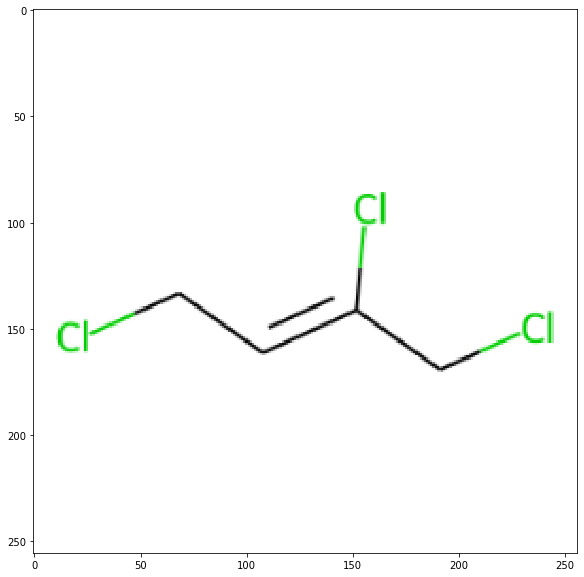

In [21]:
for image, _ in test_dataset:
    plt.imshow(image[0])
    print(type(_.numpy()))
    break

In [32]:
pred_test_value

[array([[2.7165349],
        [2.9370263],
        [2.4324045],
        [2.5974083],
        [2.393638 ],
        [2.111244 ],
        [3.5501406],
        [2.5453558],
        [2.0040753],
        [2.6352224],
        [2.237111 ],
        [2.1281934],
        [1.9130936],
        [2.4673772],
        [2.568861 ],
        [2.638688 ],
        [3.4331987],
        [2.5713253],
        [2.3549442],
        [2.3044922],
        [3.0395918],
        [2.4940393],
        [2.2509456],
        [3.2728968],
        [2.2600582],
        [2.710004 ],
        [1.8275619],
        [2.7464325],
        [2.7174325],
        [2.5568333],
        [2.0967925],
        [2.0856266]], dtype=float32),
 array([[1.9286227],
        [2.6923032],
        [3.5667439],
        [3.2016096],
        [2.3804412],
        [2.4765587],
        [2.4654973],
        [2.1144154],
        [2.4064093],
        [3.06327  ],
        [2.0038733],
        [2.8557997],
        [2.6423686],
        [2.5907555],
        [2.778552

In [36]:
len(pred_test_value)

1475

In [29]:
ans[27]

array([2.2690089], dtype=float32)

In [42]:
for image_batch, label_batch in train_dataset:
    print(label_batch)
    break

tf.Tensor(
[1.33 2.7  2.48 3.86 1.86 0.95 1.33 2.2  2.12 3.2  2.21 1.13 2.45 3.08
 2.03 4.27], shape=(16,), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


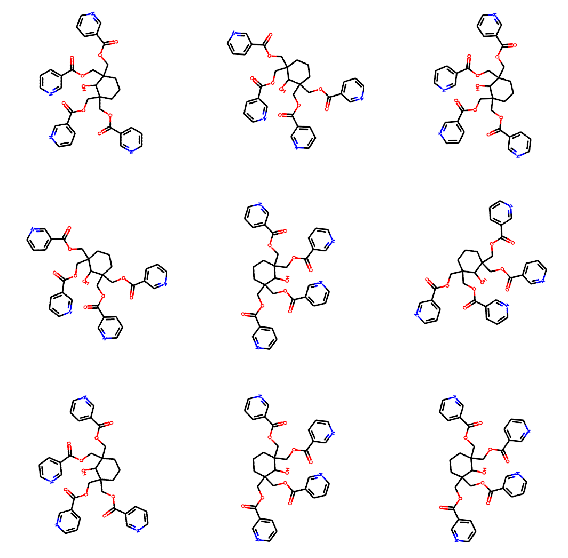

In [59]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0])
    plt.axis('off')

tf.Tensor(
[1.83 1.27 2.12 2.4  1.64 1.85 2.28 2.36 2.81 2.51 1.31 2.32 2.52 2.42
 2.49 2.3  2.59 1.08 2.4  4.12 1.53 2.4  1.92 3.14 2.44 2.7  1.66 3.96
 2.34 3.45 2.16 2.05], shape=(32,), dtype=float32)


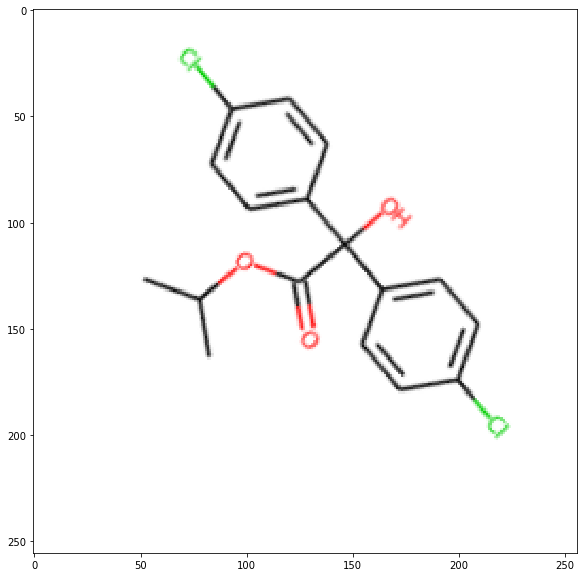

In [23]:
for image, _ in train_dataset:
    plt.imshow(data_augmentation(image[0]))
    print(_)
    break

In [37]:
for image, _ in train_dataset:
    print(_)
    break

tf.Tensor(
[4.98 1.86 2.28 2.33 1.37 4.64 1.61 1.64 1.5  2.57 2.53 3.45 2.59 2.5
 5.25 2.28 1.38 3.66 2.31 3.52 2.14 1.82 2.04 4.88 3.43 2.73 2.48 2.21
 4.51 1.17 1.75 1.27], shape=(32,), dtype=float32)
